DATASET UPLOAD TO COLAB

In [ ]:
#.upload the dataset into google colab
from google.colab import files
uploaded = files.upload()

INSTALL NECESSARY LIBRARY

In [ ]:
pip install statsmodels

In [ ]:
pip install pmdarima

In [ ]:
pip install --ignore-installed qiskit-terra qiskit-aer

In [ ]:
pip install numpy==1.19.5

In [ ]:
pip install -U scikit-learn

IMPORT LIBRARY

In [ ]:

import pandas as pd
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from math import sqrt
from pmdarima.arima import AutoARIMA
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import matplotlib.pyplot as plt
#plt.rcParams.update({'figure.figsize':(9,6), 'figure.dpi':100})
#plt.style.use('fivethirtyeight')
#plt.rcParams['axes.labelsize'] = 12
#plt.rcParams['xtick.labelsize'] = 10
#plt.rcParams['ytick.labelsize'] = 10
#plt.rcParams['text.color'] = 'G'
import numpy as np


# #READ THE SERIES AND PLOT

In [ ]:
df = pd.read_csv('tbcasesDar (1).csv')

In [ ]:
df

In [ ]:
df.dropna(inplace=True)

In [ ]:
df

In [ ]:
df['Date']= pd.to_datetime(df['date'],format="%d/%m/%y")
df.drop(columns=['date'], inplace=True)

In [ ]:
Date=df['Date']

In [ ]:
series=df.set_index('date')

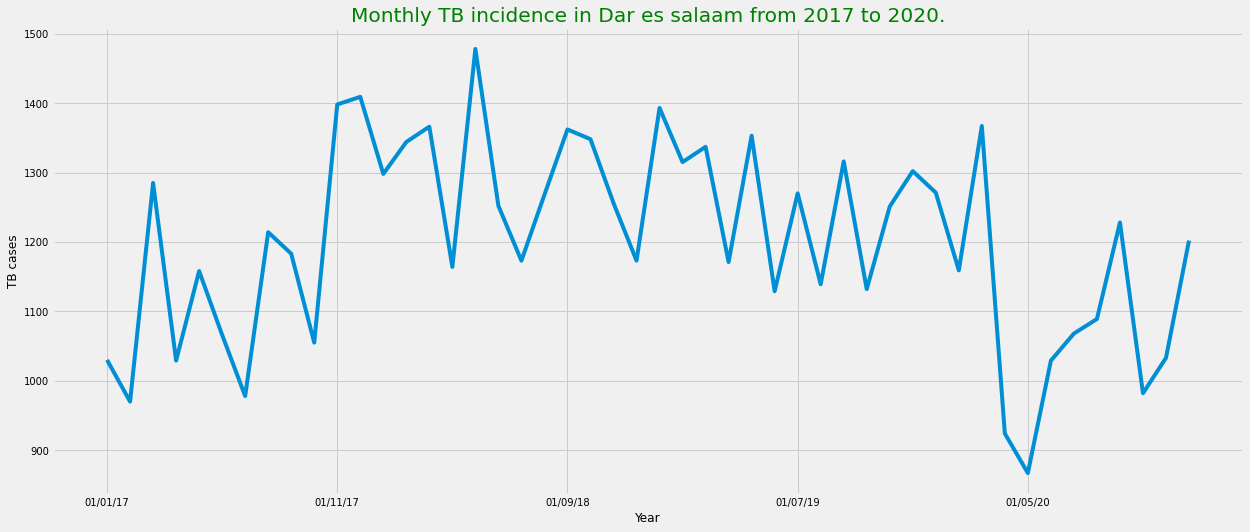

In [ ]:
series['tbcases'].plot(figsize = (19, 8),title="Monthly TB incidence in Dar es salaam from 2017 to 2020.",ylabel="TB cases",xlabel="Year")
plt.show()

DECOMPOSE THE SERIES

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [ ]:
result=sm.tsa.seasonal_decompose(series, model='additive', period=12)


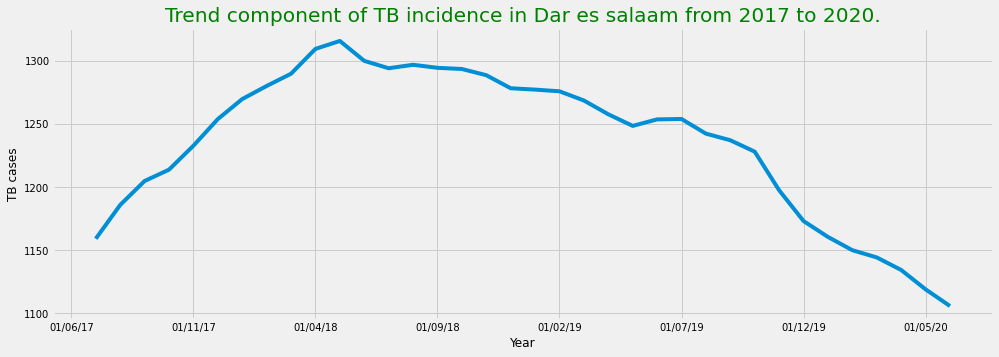

In [ ]:
result.trend.plot(title="Trend component of TB incidence in Dar es salaam from 2017 to 2020.",ylabel="TB cases",xlabel="Year")

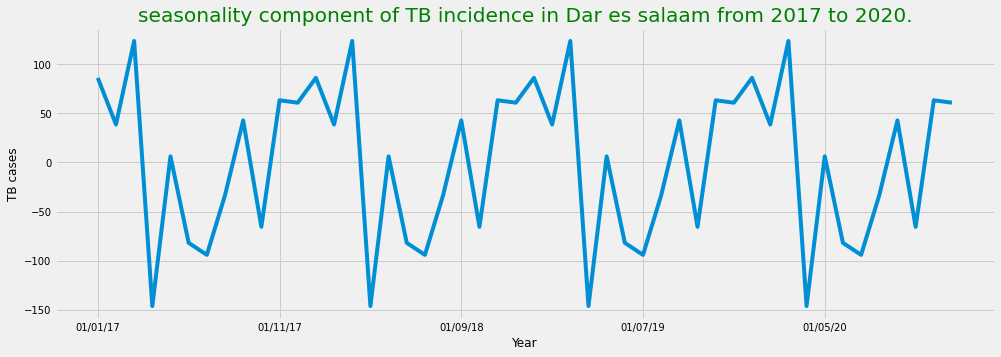

In [ ]:
result.seasonal.plot(title="seasonality component of TB incidence in Dar es salaam from 2017 to 2020.",ylabel="TB cases",xlabel="Year")

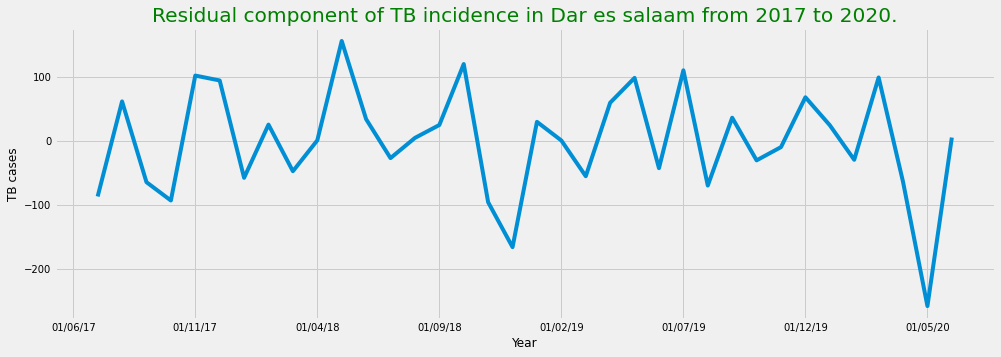

In [ ]:
result.resid.plot(title="Residual component of TB incidence in Dar es salaam from 2017 to 2020.",ylabel="TB cases",xlabel="Year")

In [ ]:
trendvalue=decomposition.trend

In [ ]:
seasonalvalue=decomposition.seasonal

In [ ]:
residualvalue=decomposition.resid

REMOVE NAN VALUE

In [ ]:
trendvalue = pd.DataFrame(trendvalue, columns = ['tbcases'])

trendvalue=trendvalue.fillna(trendvalue.mean())
print(trendvalue.isnull().sum())

In [ ]:
seasonalvalue = pd.DataFrame(seasonalvalue, columns = ['tbcases'])

seasonalvalue=seasonalvalue.fillna(seasonalvalue.mean())
print(seasonalvalue.isnull().sum())

In [ ]:
residualvalue = pd.DataFrame(residualvalue, columns = ['tbcases'])

residualvalue=residualvalue.fillna(residualvalue.mean())
print(residualvalue.isnull().sum())

TEST FOR STATIONARY (ADFULLER TEST)

In [ ]:
from statsmodels.tsa.stattools import adfuller
adfuller_results=adfuller(trendvalue,autolag='AIC')
print(f'adfuller statistics:{adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
for key,value in adfuller_results[4].items():
  print("Critical value: ")
  print(f'{key},{value}')

PLOT ACF AND PACF NON_SEASONAL

In [ ]:
import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(trendvalue)
plt.show()

In [ ]:
sgt.plot_pacf(trendvalue)
plt.show()

SPLTTING THE DATASET INTO TRAINING AND TESTING SET

In [ ]:
# split into train and test sets
X = trendvalue.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

AUTO-ARIMA TO DETERMINE OPTIMAL PARAMETER

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
model=auto_arima(X, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           seasonal=False,
                           d=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
results=model.fit(X)
print(results.summary())

VALIDATION TECHNIQUE

In [ ]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

PLOT ACTUAL VALUES VERSUS FORECAST VALUE

In [ ]:
plt.plot(test,label="test value")
plt.plot(predictions, color='red',label="Forecast value")
plt.title("Forecast values versus test  value")
plt.plot(figsize = (20, 10))
plt.legend()
plt.show()

In [ ]:
model_fit.plot_predict(dynamic=False)
plt.title("Forecast values versus Actual value")
plt.legend()
plt.show()

In [ ]:
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot(kind='kde')
plt.show()

EVALUATE A MODEL

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(forecast, actual)  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = mean_absolute_error(forecast, actual)    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.sqrt(mean_squared_error(forecast, actual))
    r2=r2_score(forecast, actual)  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,'r2_score':r2})

forecast_accuracy(predictions, test)

Forecast and plot next 12 month

In [ ]:
# Train the model on the full dataset 
model =  ARIMA(trendvalue,order = (0, 2, 1)) 
result = model.fit() 


In [ ]:
n=13
forecast,err,ci = result.forecast(steps=n,alpha=0.05)
df_forecast_arima = pd.DataFrame({'forecast':forecast},index=pd.date_range(start='01-01-2021', periods=n, freq='M'))

In [ ]:
df_forecast_arima.plot(figsize=(12, 8))

In [ ]:
df_forecast_arima

SARIMAX SEASONALITY

AUTOARIMA STATIONARY

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(seasonalvalue))

In [ ]:
# split into train and test sets
X = residualvalue.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [ ]:
len(test)

In [ ]:
seasonal_model = auto_arima(X, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [ ]:
print(seasonal_model.aic())

In [ ]:
seasonal_model.fit(history)

In [ ]:
import statsmodels.api as sm

In [ ]:
# walk-forward validation
for t in range(len(test)):
	model = sm.tsa.statespace.SARIMAX(history, order=(2,1,1),seasonal_order=(2,1,0,12))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

In [ ]:
plt.plot(test,label="test value")
plt.plot(predictions, color='red',label="Forecast value")
plt.title("Forecast values versus test  value")
plt.plot(figsize = (2, 1))
plt.legend()
plt.show()

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(forecast, actual)  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = mean_absolute_error(forecast, actual)    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.sqrt(mean_squared_error(forecast, actual))
    r2=r2_score(forecast, actual)  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,'r2_score':r2})

forecast_accuracy(predictions, test)

LSTM RESIDUAL

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

DATA PRE_PROCESSING

In [ ]:
residualvalue

In [ ]:
residualvalue['Date']=Date

In [ ]:
residualvalue=residualvalue.set_index('Date')

In [ ]:
# fix random seed for reproducibility
np.random.seed(7)

# load the dataset
dataset = residualvalue.values
dataset = dataset.astype('float32')

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

CREATE AND FIT THE MODEL

In [ ]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(50):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()


FORECAST 

In [ ]:
# make forecast
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)


In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

EVALUATE A MODEL

TRAINING PERFOMANCE METRIC

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(forecast, actual)  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = mean_absolute_error(forecast, actual)    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.sqrt(mean_squared_error(forecast, actual))
    r2=r2_score(forecast, actual)  # R2_score
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,'r2_score':r2})

forecast_accuracy(trainY[0], trainPredict[:,0])

TESTING PERFOMANCE METRIC

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(forecast, actual)  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = mean_absolute_error(forecast, actual)    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.sqrt(mean_squared_error(forecast, actual))
    r2=r2_score(forecast, actual)  # R2_score
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,'r2_score':r2})

forecast_accuracy(testY[0], testPredict[:,0])

PLOT THE RESULT FOR TRAINING AND TESTING PREDICTIONS

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [ ]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset),label="Actual value")
plt.plot(trainPredictPlot,label="forecast training value")
plt.plot(testPredictPlot,label="forecast testing value")
plt.title("Original value versus forecast training and testing value")
plt.legend()
plt.show()

FORECASTING 12 MONTH FUTURE

In [ ]:
def predict(num_prediction, model):
    prediction_list = dataset[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    

In [ ]:
def predict_dates(num_prediction):
    #last_date = lastresidual
    prediction_dates = pd.date_range("01-01-2021", periods=num_prediction+1,freq='MS').tolist()
    return prediction_dates

num_prediction = 12
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [ ]:
forecast = scaler.inverse_transform([forecast])

In [ ]:
forecast

In [ ]:
forecast=forecast.reshape(13,1)

In [ ]:
#convert to dataframe and add tbcases colomn to the dataframe
from pandas import DataFrame


residualdata = DataFrame (forecast_dates,columns=['Date'])
print (residualdata)

In [ ]:
residualdata['TB cases']=forecast

In [ ]:
residualdata

In [ ]:
residual_foreast=residualdata['TB cases']

In [ ]:
rs3=residual_foreast.values

In [ ]:
series3 = pd.Series(rs3);

HYBRID RESULT

In [ ]:
rs=series1+series2+series3

In [ ]:
rs

In [ ]:
futureDate = DataFrame (forecast_dates,columns=['Date'])
print (futureDate)

In [ ]:
futureDate['TB cases']=rs

In [ ]:
futureDate

In [ ]:
futureDate=futureDate.set_index('Date')

In [ ]:
futureDate.plot(figsize = (19, 8),title="Forecast Monthly New and Relapse (bacteriologically confirmed or clinical diagnosis) TB incidence at Kibongoto Infectious Disease Hospital  from 2015 to 2020.",ylabel="New and Relapse TB cases",xlabel="Year")
plt.show()